In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bnlpsentiment-analysis/bn_glove.39M.100d.txt
/kaggle/input/bnlpsentiment-analysis/bnwiki_word2vec.model.syn1neg.npy
/kaggle/input/bnlpsentiment-analysis/bnwiki_word2vec.vector
/kaggle/input/bnlpsentiment-analysis/bnwiki_word2vec.model.wv.vectors.npy
/kaggle/input/bnlpsentiment-analysis/banglasentimentanalysis.csv
/kaggle/input/bnlpsentiment-analysis/bnwiki_word2vec.model


In [2]:
#Importing dependencies
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import matplotlib.pyplot as plt

# Training 
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,GRU
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D,GlobalMaxPool1D
from tensorflow.keras.regularizers import l2

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
df = pd.read_csv('/kaggle/input/bnlpsentiment-analysis/banglasentimentanalysis.csv')
df.head()

,Unnamed: 0,Reviews,Label
0,0,অনেক সুন্দর নাটক,1.0
1,1,সত্যি গল্পটা অনেক ভালো ছিল।কিছু কিছু মানুসের ...,1.0
2,2,ভাদামো মোসারফ করিম। 🤤,0.0
3,3,বালের নাটক,0.0
4,4,ফালতু নাটক,0.0


In [4]:
#Removing index column
# df = pd.DataFrame(df)
df = df.drop(['Unnamed: 0'],axis=1)
df.head()

,Reviews,Label
0,অনেক সুন্দর নাটক,1.0
1,সত্যি গল্পটা অনেক ভালো ছিল।কিছু কিছু মানুসের ...,1.0
2,ভাদামো মোসারফ করিম। 🤤,0.0
3,বালের নাটক,0.0
4,ফালতু নাটক,0.0


In [5]:
# Null value check
df.isnull().sum()

Reviews    4
Label      2
dtype: int64

In [6]:
df.dropna(axis=0, how='any', subset=['Reviews', 'Label'], inplace=True)
df.isnull().sum()

Reviews    0
Label      0
dtype: int64

In [7]:
# Changing the 'Label' type
print(df.Label.unique())
df["Label"]=df["Label"].astype(int)
print(df.Label.unique())

[1. 0.]
[1 0]


<Axes: xlabel='Label', ylabel='count'>

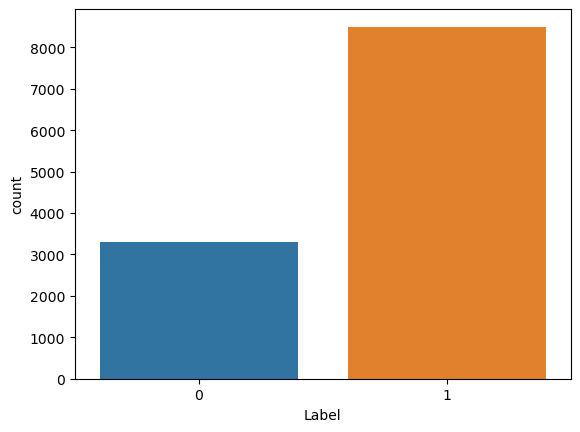

In [8]:
# Check if oversampling or undersampling required
sns.countplot(x="Label",data = df)

In [9]:
review = df.Reviews
label = df.Label

In [10]:
# Tokenizing the given reviews
max_words = 4000
max_review_len = 128
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(review)
# word_index
sequences = tokenizer.texts_to_sequences(review)
word_index = tokenizer.word_index
# word_index
len(word_index)

19127

In [11]:
# Maximum words in a sequence
max_length = 0

for review_num in range(len(sequences)):
#     print(len(onehot_rep[review_num]))
    if len(sequences[review_num]) > max_length:
        max_length = len(sequences[review_num])
max_length

219

In [12]:
# Padding the sequence
data = pad_sequences(sequences, maxlen=max_review_len)
print(data)
data.shape

[[   0    0    0 ...    3    5    1]
 [   0    0    0 ...  654   70  905]
 [   0    0    0 ...    0 1743 3439]
 ...
 [   0    0    0 ...   14   55    8]
 [   0    0    0 ...   48   20  556]
 [   0    0    0 ...   92  407  596]]


(11807, 128)

In [13]:
# Embedding
file = open('/kaggle/input/bnlpsentiment-analysis/bn_glove.39M.100d.txt')
embedding_list = {}
for i in file:
    line = i.split()
#     print(line[0])
    word = line[0]
    values = np.asarray(line[1:], dtype='float32')
    embedding_list[word] = values
file.close()
# embedding_list['এবং'].dtype
len(embedding_list)

178153

In [14]:
embedding_dim = 100 
embedding_matrix = np.zeros((len(word_index)+1, embedding_dim))
embedding_matrix.shape

(19128, 100)

In [15]:
# Creating weight matrix of word
for word,i in word_index.items():
    embedding_vector = embedding_list.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
embedding_matrix[10].shape
# word_index.items()

(100,)

In [16]:
# Convolution
kernel_size = 3
filters = 32

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 128, 100)          1912800   
                                                                 
 lstm (LSTM)                 (None, 128, 128)          117248    
                                                                 
 conv1d (Conv1D)             (None, 128, 32)           12320     
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                        

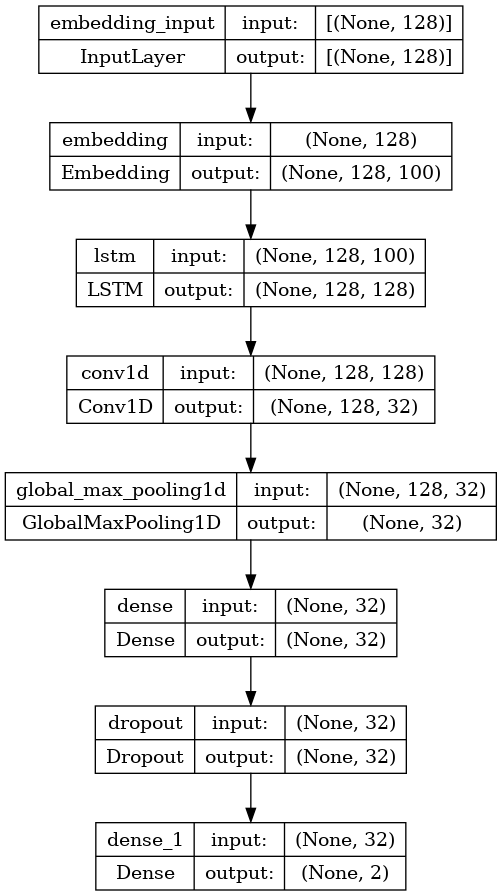

In [17]:
voc_size = len(word_index)+1

model_1 = Sequential()
model_1.add(Embedding(voc_size,embedding_dim,weights=[embedding_matrix],input_length=max_review_len,trainable=False))
model_1.add(LSTM(128,dropout=0.2,return_sequences=True))
model_1.add(Conv1D(filters, kernel_size, padding='same', activation='relu'))
model_1.add(GlobalMaxPool1D())
model_1.add(Dense(32,activation = 'relu',kernel_regularizer = l2(0.001)))
model_1.add(Dropout(0.2))
model_1.add(Dense(2,activation='softmax'))
model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_1.summary()
tf.keras.utils.plot_model(model_1, to_file='model.png', show_shapes=True)

In [18]:
# Splitting dataset for Training & Test
from sklearn.model_selection import train_test_split
x = data
y = label
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

In [19]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(9445, 128)
(9445,)
(2362, 128)
(2362,)


In [20]:
y_test = to_categorical(y_test)
y_train = to_categorical(y_train)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(9445, 128)
(9445, 2)
(2362, 128)
(2362, 2)


In [21]:
# Early stopping callback & reduction of learning rate
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, mode='min',restore_best_weights=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='loss',patience=4,verbose=1,factor=0.5,min_lr=0.00001)
callbacks = [early_stopping_callback,learning_rate_reduction]

In [22]:
# Fitting in the model
history = model_1.fit(X_train,y_train,epochs = 20,batch_size=64,validation_data = (X_test,y_test),callbacks = [callbacks])

Epoch 1/20
148/148 [==============================] - 35s 214ms/step - loss: 0.4252 - accuracy: 0.8192 - val_loss: 0.3118 - val_accuracy: 0.8658 - lr: 0.0010
Epoch 2/20
148/148 [==============================] - 31s 209ms/step - loss: 0.2946 - accuracy: 0.8803 - val_loss: 0.2636 - val_accuracy: 0.8899 - lr: 0.0010
Epoch 3/20
148/148 [==============================] - 31s 210ms/step - loss: 0.2497 - accuracy: 0.9010 - val_loss: 0.2306 - val_accuracy: 0.9081 - lr: 0.0010
Epoch 4/20
148/148 [==============================] - 31s 210ms/step - loss: 0.2235 - accuracy: 0.9128 - val_loss: 0.2167 - val_accuracy: 0.9200 - lr: 0.0010
Epoch 5/20
148/148 [==============================] - 31s 211ms/step - loss: 0.2056 - accuracy: 0.9214 - val_loss: 0.2074 - val_accuracy: 0.9242 - lr: 0.0010
Epoch 6/20
148/148 [==============================] - 31s 212ms/step - loss: 0.1790 - accuracy: 0.9325 - val_loss: 0.1957 - val_accuracy: 0.9323 - lr: 0.0010
Epoch 7/20
148/148 [==============================] 

In [23]:
from tensorflow.keras.models import load_model

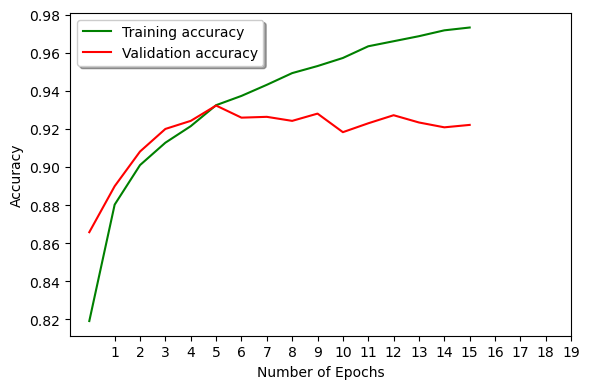

In [24]:
#plotting validation and training accuracy and loss

epochs=20
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], color='g', label="Training accuracy")
plt.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
plt.xticks(np.arange(1, epochs, 1))
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

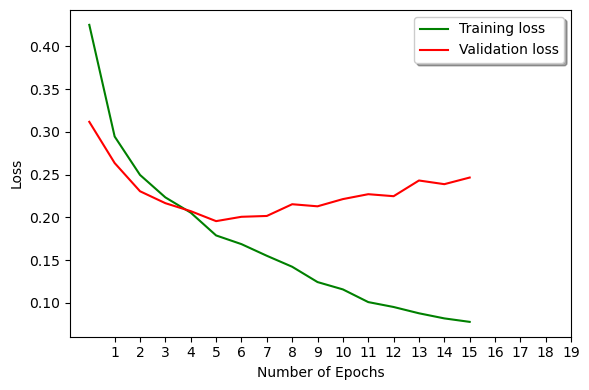

In [25]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], color='g', label="Training loss")
plt.plot(history.history['val_loss'], color='r',label="Validation loss")
plt.xticks(np.arange(1, epochs, 1))
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [26]:
# Prediction
y_pred_1 = model_1.predict(X_test)

74/74 [==============================] - 5s 58ms/step


In [27]:
# Confusion matrix on our prediction by model_1
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(y_pred_1,axis=1))
print(cm)
print(accuracy_score(np.argmax(y_test,axis=1), np.argmax(y_pred_1,axis=1)))

[[ 585   76]
 [  84 1617]]
0.9322607959356477
